In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

%config IPCompleter.greedy=True

# Data

In [89]:
item_categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
sales_train = pd.read_csv("sales_train.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")

### Descriptive stats

In [3]:
def get_descriptive_stats(df):
    print("SHAPE:")
    print(df.shape)
    print("\n\n")
    print("SAMPLE:")
    print(df.head(5))
    print("\n\n")
    print("#UNIQUE:")
    print(df.nunique())
    print("\n\n")
    print("MISSING VALUES:")
    print(df.isnull().sum())
    print("\n\n")
    print("DESCRIPTIVES:")
    print(df.describe())

In [4]:
get_descriptive_stats(items)

SHAPE:
(22170, 3)



SAMPLE:
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  



#UNIQUE:
item_name           22170
item_id             22170
item_category_id       84
dtype: int64



MISSING VALUES:
item_name           0
item_id             0
item_category_id    0
dtype: int64



DESCRIPTIVES:
           item_id  item_category_id
count  22170.00000      22170.000000
mean   11084.50000         46.290753
std     6400.07207         15.941486
min        0.00000          0.000000
25%     5542.25000         37.000000
50%    1

In [5]:
get_descriptive_stats(item_categories)

SHAPE:
(84, 2)



SAMPLE:
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4



#UNIQUE:
item_category_name    84
item_category_id      84
dtype: int64



MISSING VALUES:
item_category_name    0
item_category_id      0
dtype: int64



DESCRIPTIVES:
       item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000


In [6]:
get_descriptive_stats(shops)

SHAPE:
(60, 2)



SAMPLE:
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4



#UNIQUE:
shop_name    60
shop_id      60
dtype: int64



MISSING VALUES:
shop_name    0
shop_id      0
dtype: int64



DESCRIPTIVES:
         shop_id
count  60.000000
mean   29.500000
std    17.464249
min     0.000000
25%    14.750000
50%    29.500000
75%    44.250000
max    59.000000


In [7]:
get_descriptive_stats(sales_train)

SHAPE:
(2935849, 6)



SAMPLE:
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0



#UNIQUE:
date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64



MISSING VALUES:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64



DESCRIPTIVES:
       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173

# Simple baseline

We first create 2 simple baselines.

In [8]:
# Simple baseline 1: compute average sales per shop+item in November 2013/2014 and average over the 2 years.
sales_train['month'] = sales_train['date'].apply(lambda x: x.split('.')[-2])
sales_train['year'] = sales_train['date'].apply(lambda x: x.split('.')[-1])
november_only = sales_train[sales_train.month=='11']

avg_grouped = november_only.groupby(['shop_id','item_id']).agg({'item_cnt_day':'sum'})
avg_grouped['item_cnt_day'] /= 2. # number of novembers in training set

merged_with_test = test.merge(avg_grouped,on=['shop_id','item_id'],how='left').fillna(0) # if no sales predict 0

submission_file = merged_with_test.reset_index()[['ID','item_cnt_day']]
submission_file = submission_file.rename(mapper={'item_cnt_day':'item_cnt_month'},axis=1)
submission_file.to_csv("submissions/november_average.csv",index=False)

#### Score: 3.14800

In [9]:
# Simple baseline 2: compute average sales per shop+item in each month of the training period and predict the average.
all_sales = sales_train.copy()

avg_grouped = all_sales.groupby(['shop_id','item_id']).agg({'item_cnt_day':'sum'})
avg_grouped['item_cnt_day'] /= 34. # number of months in training set

merged_with_test = test.merge(avg_grouped,on=['shop_id','item_id'],how='left').fillna(0) # if no sales predict 0

submission_file = merged_with_test.reset_index()[['ID','item_cnt_day']]
submission_file = submission_file.rename(mapper={'item_cnt_day':'item_cnt_month'},axis=1)
submission_file.to_csv("submissions/monthly_average.csv",index=False)

#### Score: 2.04648

# EDA

## Items

In [10]:
get_descriptive_stats(items)

SHAPE:
(22170, 3)



SAMPLE:
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  



#UNIQUE:
item_name           22170
item_id             22170
item_category_id       84
dtype: int64



MISSING VALUES:
item_name           0
item_id             0
item_category_id    0
dtype: int64



DESCRIPTIVES:
           item_id  item_category_id
count  22170.00000      22170.000000
mean   11084.50000         46.290753
std     6400.07207         15.941486
min        0.00000          0.000000
25%     5542.25000         37.000000
50%    1

In [11]:
items['item_name'].head(10)

0            ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
1    !ABBYY FineReader 12 Professional Edition Full...
2        ***В ЛУЧАХ СЛАВЫ   (UNV)                    D
3      ***ГОЛУБАЯ ВОЛНА  (Univ)                      D
4          ***КОРОБКА (СТЕКЛО)                       D
5    ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...
6             ***УДАР ПО ВОРОТАМ (UNI)               D
7           ***УДАР ПО ВОРОТАМ-2 (UNI)               D
8             ***ЧАЙ С МУССОЛИНИ                     D
9        ***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI)             D
Name: item_name, dtype: object

* The items seem to have an indication of the type of item after the product name in either square '[]' or round '()' brackets. Are those correlated with the category id?

In [12]:
items['item_name_bracketed'] = items['item_name'].apply(lambda x:  x[x.find("(")+1:x.find(")")] if x.find('(')>0 else (x[x.find("[")+1:x.find("]")] if x.find('[')>0 else ''))
items['item_name_bracketed']

0                     ПЛАСТ.
1        PC, Цифровая версия
2                        UNV
3                       Univ
4                     СТЕКЛО
                ...         
22165    PC, Цифровая версия
22166        Цифровая версия
22167                    +CD
22168                       
22169         Игра престолов
Name: item_name_bracketed, Length: 22170, dtype: object

In [13]:
items[['item_name_bracketed','item_category_id']].head(30)

,item_name_bracketed,item_category_id
0,ПЛАСТ.,40
1,"PC, Цифровая версия",76
2,UNV,40
3,Univ,40
4,СТЕКЛО,40
5,UNI,40
6,UNI,40
7,UNI,40
8,,40
9,UNI,40


* Doesn't seem to be the case so probably we can get more information by also processing this

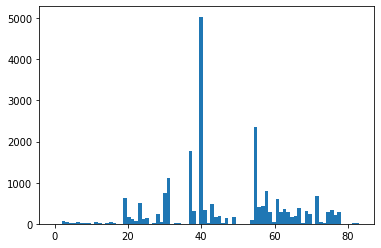

In [14]:
plt.hist(items['item_category_id'],bins=items['item_category_id'].nunique());

## Shops

In [15]:
get_descriptive_stats(shops)

SHAPE:
(60, 2)



SAMPLE:
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4



#UNIQUE:
shop_name    60
shop_id      60
dtype: int64



MISSING VALUES:
shop_name    0
shop_id      0
dtype: int64



DESCRIPTIVES:
         shop_id
count  60.000000
mean   29.500000
std    17.464249
min     0.000000
25%    14.750000
50%    29.500000
75%    44.250000
max    59.000000


In [16]:
shops.head(100)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


* Google tells me 'Москва' means 'Moscow', so probably the first word is the city, we can extract this as a feature.
* Some shops seem to be duplicates (for example 0 and 57).


## Item Categories

In [17]:
get_descriptive_stats(item_categories)

SHAPE:
(84, 2)



SAMPLE:
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4



#UNIQUE:
item_category_name    84
item_category_id      84
dtype: int64



MISSING VALUES:
item_category_name    0
item_category_id      0
dtype: int64



DESCRIPTIVES:
       item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000


In [18]:
item_categories.head(50)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


We can extract a few things here:
* There seems to be a lot of information about the device, for example 'PC' or 'PSN'.
* There are also more broader categories hidden here, for example 'Кино' means 'film', so all categories containing 'Кино' are about film sales.

## Sales train

In [19]:
get_descriptive_stats(sales_train)

SHAPE:
(2935849, 8)



SAMPLE:
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

  month  year  
0    01  2013  
1    01  2013  
2    01  2013  
3    01  2013  
4    01  2013  



#UNIQUE:
date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
month                12
year                  3
dtype: int64



MISSING VALUES:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
month             0
year              0
dtype: int64



A few additional problems from the descriptive stats:

In [20]:
sorted(sales_train['item_price'])[:10]

[-1.0, 0.07, 0.07, 0.0875, 0.09, 0.1, 0.1, 0.1, 0.1, 0.1]

In [21]:
sorted(sales_train['item_price'])[-10:]

[41990.0,
 42000.0,
 42990.0,
 42990.0,
 42990.0,
 42990.0,
 49782.0,
 50999.0,
 59200.0,
 307980.0]

In [22]:
sorted(sales_train['item_cnt_day'])[:10]

[-22.0, -16.0, -9.0, -6.0, -6.0, -5.0, -5.0, -5.0, -5.0, -4.0]

In [23]:
sorted(sales_train['item_cnt_day'])[-10:]

[504.0, 508.0, 512.0, 533.0, 539.0, 624.0, 637.0, 669.0, 1000.0, 2169.0]

* Major problems see the item price of -1 -> we set this to the median price
* Highest item price is too high and might skew the data, set to 2nd highest price

In [24]:
sales_train['item_price'].replace({307980.0:59200},inplace=True)

In [25]:
sales_train['item_price'].replace({-1.0:np.median(sales_train.item_price)},inplace=True)


In [26]:
sales_train.item_price.describe()

count    2.935849e+06
mean     8.907686e+02
std      1.720826e+03
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      5.920000e+04
Name: item_price, dtype: float64

# Data Leakage

Data leakage in this case could happen if information about the test set is present in the training data. However the train and test set in this case are strictly split on time, where the training set stops in october 2015 (and we need to predict for November 2015):

In [27]:
sales_train['year_month'] = sales_train['year'].astype(str) + '-' + sales_train['month'].astype(str)
sales_train.year_month.max()

'2015-10'

However what could happen is that some of the shops are closed or some of the products are not being sold anymore, in which case the future sales of the shop/item will be 0. To estimate if this happens let's look at the last time a shop sold any item or the last time a specific item was sold. 

In [28]:
closed_shops = sales_train[sales_train.groupby('shop_id')['year_month'].transform('max')<'2015-10'].shop_id.unique()
closed_shops

array([23, 27, 29,  0,  1,  8, 13, 30, 32, 54, 43, 51, 17, 40, 33, 11])

It seems a couple of shops haven't sold anything in a few years! So they are most likely closed. However this is only directly useful if we need to predict stuff for those shops. Let's see which shops are in the test set:

In [29]:
set(test.shop_id.unique()).intersection(closed_shops)

set()

No shops are closed in the test set, so we can't use this information. How about the items?

In [30]:
closed_items = sales_train[sales_train.groupby('item_id')['year_month'].transform('max')<'2014-10'].item_id.unique()
closed_items

array([2554, 2565, 2572, ..., 5696, 5705, 6381])

In [31]:
overlap = set(test.item_id.unique()).intersection(closed_items)

We have some items that were not sold after 2014-10 but appear in the test set! I'm looking further back then in the case of shops since we can imagine every shop to have at lesat 1 sale in a month but for items it could esaily happen that some months no sales for a particular item were made. Let's say if the item hasn't been sold in a year (hence the 2014-10) it's most likely not going to be sold as well in 2015-11. Let's have a look to confirm we did it correctly.

In [32]:
for i in overlap:
    print(i)
    print(sales_train[sales_train.item_id==i].groupby('year_month').sum()[['item_cnt_day']])

524
            item_cnt_day
year_month              
2013-05              1.0
2013-07              1.0
2013-10              2.0
2013-11              1.0
8214
            item_cnt_day
year_month              
2013-02              1.0
2013-08              1.0
18467
            item_cnt_day
year_month              
2013-01              7.0
2013-02              5.0
2013-03             11.0
2013-04              3.0
2013-06              1.0
2013-07              5.0
2013-08              6.0
2013-10              3.0
2013-11              1.0
2013-12              4.0
2014-01              3.0
2014-02              1.0
2014-03              2.0
2014-04              1.0
2014-07              1.0
17448
            item_cnt_day
year_month              
2013-10             10.0
2013-11             15.0
2013-12             16.0
2014-01              6.0
2014-02              2.0
2014-03              4.0
2014-04              2.0
2014-05              3.0
2014-06              4.0
2014-07              3.0
5162

Okay, let's predict 0 for those!

# Feature engineering

In [33]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,year_month
0,02.01.2013,0,59,22154,999.00,1.0,01,2013,2013-01
1,03.01.2013,0,25,2552,899.00,1.0,01,2013,2013-01
2,05.01.2013,0,25,2552,899.00,-1.0,01,2013,2013-01
3,06.01.2013,0,25,2554,1709.05,1.0,01,2013,2013-01
4,15.01.2013,0,25,2555,1099.00,1.0,01,2013,2013-01


Given that we are trying to predict sales for a particular shop-item pair for a month, it probably makes sense to look at lagged features in this case; i.e. the sale of a particular item/shop combination is probably well predicted by the sales of the shop, item or item + shop sales in the last X months, for different values of X. The data we are given is based on daily data, since we are only interested in monthly data it makes sense to aggregate the data first on a per month basis. So to generate a set of features we do the following:

* aggregate the data by month, since we assume the price to be relatively constant over a month, we take the mean of an item per shop and month
* add broad categories, devices and city as found by EDA above
* add last 1, 3, 6, 12 months of sales data for the shopxitem, shop, item, itemxcity, city combinations

Since I haven't used target mean encoding before and I want to learn how to do this:
* for categorical variables, we will try both one-hot encoding and mean encoding with smoothing to compare performance

### Aggregate by month


In [34]:
# Якутск Орджоникидзе, 56
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [35]:
train_x = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum', 'item_price':'mean'}).reset_index()
train_x

,date_block_num,shop_id,item_id,item_cnt_day,item_price
0,0,2,27,1.0,2499.0
1,0,2,33,1.0,499.0
2,0,2,317,1.0,299.0
3,0,2,438,1.0,299.0
4,0,2,471,2.0,399.0
...,...,...,...,...,...
1609119,33,59,22087,6.0,119.0
1609120,33,59,22088,2.0,119.0
1609121,33,59,22091,1.0,179.0
1609122,33,59,22100,1.0,629.0


In [36]:
train_x[train_x.item_id==2]

,date_block_num,shop_id,item_id,item_cnt_day,item_price
1059283,19,54,2,1.0,58.0
1188463,22,54,2,1.0,58.0


In [37]:
sales_train[(sales_train.date_block_num==0)&(sales_train.shop_id==0)&(sales_train.item_id==32)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,year_month


In [38]:
test.groupby('item_id').count()

,ID,shop_id
item_id,,
30,42,42
31,42,42
32,42,42
33,42,42
38,42,42
...,...,...
22162,42,42
22163,42,42
22164,42,42


In the test set we have combinations of a lot of shops and items (5100 items, 42 shops, same items for each of the shops) and so we will predict 0 a lot of times since not all shops sell the same stuff. Additionally, we have 8% of the entries in test for only 1/33th of the time of window of training data sales, further indicating we probably want to predict 0 for samples in the test set. The training set however we only have non-zero item sales. We will fill the training matrix with 0 values for shops, items and date blocks (i.e. months) that are not yet in the training data. Idea gotten from here: https://www.kaggle.com/dlarionov/feature-engineering-xgboost as it will most likely be similar to what we have for test, it looks like all sold items of any shop were taken and then a prediction is needed for each itemxshop for each item that saw a sale in month 34, regardless of the shop. We can easily mimic this in the training set by looking at the full product of all items and shops that saw at least one sale, see below:

In [39]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train_x[train_x.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

Now we can merge the df back, set the counts to zero if NaN. We also compute the average item price as a feature.

In [40]:
train_x = matrix.merge(train_x,on=['date_block_num','shop_id','item_id'],how='left')
train_x['item_cnt_day'] = train_x['item_cnt_day'].fillna(0)
train_x = train_x.rename(mapper={'item_cnt_day':'item_cnt_month'},axis=1)
train_x

,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,2,19,0.0,NaN
1,0,2,27,1.0,2499.0
2,0,2,28,0.0,NaN
3,0,2,29,0.0,NaN
4,0,2,32,0.0,NaN
...,...,...,...,...,...
10913845,33,59,22162,0.0,NaN
10913846,33,59,22163,0.0,NaN
10913847,33,59,22164,0.0,NaN
10913848,33,59,22166,0.0,NaN


In [41]:
train_x[(train_x.item_id==2) & (train_x.shop_id==54)]

,date_block_num,shop_id,item_id,item_cnt_month,item_price
7110828,19,54,2,1.0,58.0
8060091,22,54,2,1.0,58.0


### Merge with test data to apply feature engineering and transofrmations to both train and test

In [42]:
test_x = test.drop('ID',axis=1).copy()
test_x['date_block_num'] = 34
test_x['item_cnt_month'] = np.NAN
test_x

,shop_id,item_id,date_block_num,item_cnt_month
0,5,5037,34,NaN
1,5,5320,34,NaN
2,5,5233,34,NaN
3,5,5232,34,NaN
4,5,5268,34,NaN
...,...,...,...,...
214195,45,18454,34,NaN
214196,45,16188,34,NaN
214197,45,15757,34,NaN
214198,45,19648,34,NaN


Imputing missing item prices with the median of item prices and merging with train_x

In [43]:
all_x = train_x.append(test_x)

# Cleanup
import gc
del train_x, test_x, sales_train, all_sales, november_only, merged_with_test, test
gc.collect()

all_x

,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,2,19,0.0,NaN
1,0,2,27,1.0,2499.0
2,0,2,28,0.0,NaN
3,0,2,29,0.0,NaN
4,0,2,32,0.0,NaN
...,...,...,...,...,...
214195,34,45,18454,NaN,NaN
214196,34,45,16188,NaN,NaN
214197,34,45,15757,NaN,NaN
214198,34,45,19648,NaN,NaN


In [44]:
all_x[(all_x.item_id==2) & (all_x.shop_id==54)]

,date_block_num,shop_id,item_id,item_cnt_month,item_price
7110828,19,54,2,1.0,58.0
8060091,22,54,2,1.0,58.0


### Add shop and item features

In [45]:
shops.columns

Index(['shop_name', 'shop_id'], dtype='object')

In [46]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops.shop_name.apply(lambda x: x.split(' ')[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [47]:
shops.groupby('city').count().sort_values(by='shop_name',ascending=False).head()

,shop_name,shop_id
city,,
Москва,13,13
Якутск,4,4
РостовНаДону,3,3
Воронеж,3,3
Тюмень,3,3


In [48]:
all_x = all_x.merge(shops,on=['shop_id'])
all_x.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price',
       'shop_name', 'city'],
      dtype='object')

In [49]:
item_categories.columns

Index(['item_category_name', 'item_category_id'], dtype='object')

In [50]:
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['broad_category'] = item_categories['split'].map(lambda x: x[0].strip())

In [51]:
item_categories.groupby('broad_category').count()

,item_category_name,item_category_id,split
broad_category,,,
PC,1,1,1
Аксессуары,7,7,7
Билеты (Цифра),1,1,1
Доставка товара,1,1,1
Игровые консоли,8,8,8
Игры,8,8,8
Игры Android,1,1,1
Игры MAC,1,1,1
Игры PC,4,4,4


First one seems to be the device in stead of the broader category, let's put that in it's own category (so we will leave it as is, the other words there, i.e. Гарнитуры/Наушники seem to be unique).

In [52]:
item_categories['device_category'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

In [53]:
item_categories.head(5)

,item_category_name,item_category_id,split,broad_category,device_category
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,PS2
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,PS3
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,PS4
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,PSP


In [54]:
all_x = all_x.merge(items,on=['item_id']).merge(item_categories,on=['item_category_id'])

In [55]:
all_x = all_x.drop(columns=['shop_name', 'item_name', 'item_name_bracketed', 'item_category_name', 'split'], axis=1)

In [56]:
all_x

,date_block_num,shop_id,item_id,item_cnt_month,item_price,city,item_category_id,broad_category,device_category
0,0,2,19,0.0,NaN,Адыгея,40,Кино,DVD
1,0,3,19,0.0,NaN,Балашиха,40,Кино,DVD
2,0,4,19,0.0,NaN,Волжский,40,Кино,DVD
3,0,6,19,0.0,NaN,Воронеж,40,Кино,DVD
4,0,7,19,0.0,NaN,Воронеж,40,Кино,DVD
...,...,...,...,...,...,...,...,...,...
11128045,34,49,13096,NaN,NaN,Тюмень,36,Карты оплаты,Windows (Цифра)
11128046,34,39,13096,NaN,NaN,РостовНаДону,36,Карты оплаты,Windows (Цифра)
11128047,34,48,13096,NaN,NaN,Томск,36,Карты оплаты,Windows (Цифра)
11128048,34,34,13096,NaN,NaN,Н.Новгород,36,Карты оплаты,Windows (Цифра)


In [57]:
all_x.groupby('item_id').count()

,date_block_num,shop_id,item_cnt_month,item_price,city,item_category_id,broad_category,device_category
item_id,,,,,,,,
0,50,50,50,1,50,50,50,50
1,252,252,252,5,252,252,252,252
2,101,101,101,2,101,101,101,101
3,101,101,101,2,101,101,101,101
4,50,50,50,1,50,50,50,50
...,...,...,...,...,...,...,...,...
22165,94,94,94,2,94,94,94,94
22166,1218,1218,1176,25,1218,1218,1218,1218
22167,1263,1263,1221,448,1263,1263,1263,1263


In [58]:
all_x[(all_x.item_id==2) & (all_x.shop_id==54)]

,date_block_num,shop_id,item_id,item_cnt_month,item_price,city,item_category_id,broad_category,device_category
2304438,19,54,2,1.0,58.0,Химки,40,Кино,DVD
2304439,22,54,2,1.0,58.0,Химки,40,Кино,DVD


### Adding lagged time features

In [59]:
# we need to do some memory management first
all_x.dtypes

date_block_num        int64
shop_id               int64
item_id               int64
item_cnt_month      float64
item_price          float64
city                 object
item_category_id      int64
broad_category       object
device_category      object
dtype: object

In [60]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for x in ['city', 'broad_category', 'device_category']:
    all_x[x] = le.fit_transform(all_x[x])

In [61]:
all_x = all_x.fillna(0).astype(
    {
        'date_block_num' : np.int8
        , 'shop_id' : np.int8
        , 'item_id' : np.int16
        , 'item_cnt_month' : np.float16
        , 'item_price' : np.float16
        , 'item_category_id' : np.int8
        , 'city': np.int8
        , 'broad_category': np.int16
        , 'device_category': np.int16
    })
all_x.dtypes

date_block_num         int8
shop_id                int8
item_id               int16
item_cnt_month      float16
item_price          float16
city                   int8
item_category_id       int8
broad_category        int16
device_category       int16
dtype: object

In [62]:
all_x[(all_x.item_id==2) & (all_x.shop_id==54)]

,date_block_num,shop_id,item_id,item_cnt_month,item_price,city,item_category_id,broad_category,device_category
2304438,19,54,2,1.0,58.0,26,40,11,4
2304439,22,54,2,1.0,58.0,26,40,11,4


In [63]:
def lag_feature(df, lags, col, group, col_name):
    # For item price we look at average price with lag
    tmp = df[group+[col]].groupby(group).mean().reset_index()    
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = group + [col_name+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=group, how='left')
        df = df.astype({col_name+'_lag_'+str(i) : np.float16})
        del shifted
    del tmp
    return df

In [64]:
all_x = lag_feature(all_x, [1,3,6,12], 'item_cnt_month', ['date_block_num', 'shop_id', 'item_id'], 'item_shop_cnt_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_cnt_month', ['date_block_num', 'shop_id'], 'shop_cnt_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_cnt_month', ['date_block_num', 'item_id'], 'item_cnt_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_cnt_month', ['date_block_num', 'city'], 'city_cnt_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_cnt_month', ['date_block_num', 'city', 'item_id'], 'city_item_cnt_month')

all_x = lag_feature(all_x, [1,3,6,12], 'item_cnt_month', ['date_block_num'], 'cnt_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_cnt_month', ['date_block_num', 'item_category_id'], 'item_cat_cnt_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_cnt_month', ['date_block_num', 'broad_category'], 'broad_cat_cnt_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_cnt_month', ['date_block_num', 'device_category'], 'dev_cat_cnt_month')

all_x = lag_feature(all_x, [1,3,6,12], 'item_cnt_month', ['date_block_num', 'item_category_id', 'shop_id'], 'item_cat_shop_cnt_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_cnt_month', ['date_block_num', 'broad_category', 'shop_id'], 'broad_cat_shop_cnt_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_cnt_month', ['date_block_num', 'device_category', 'shop_id'], 'dev_cat_shop_cnt_month')


all_x = lag_feature(all_x, [1,3,6,12], 'item_price', ['date_block_num', 'shop_id', 'item_id'], 'item_shop_price_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_price', ['date_block_num', 'shop_id'], 'shop_price_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_price', ['date_block_num', 'item_id'], 'item_price_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_price', ['date_block_num', 'city'], 'city_price_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_price', ['date_block_num', 'city', 'item_id'], 'city_item_price_month')

all_x = lag_feature(all_x, [1,3,6,12], 'item_price', ['date_block_num'], 'price_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_price', ['date_block_num', 'item_category_id'], 'item_cat_price_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_price', ['date_block_num', 'broad_category'], 'broad_cat_price_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_price', ['date_block_num', 'device_category'], 'dev_cat_price_month')

all_x = lag_feature(all_x, [1,3,6,12], 'item_price', ['date_block_num', 'item_category_id', 'shop_id'], 'item_cat_shop_price_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_price', ['date_block_num', 'broad_category', 'shop_id'], 'broad_cat_shop_price_month')
all_x = lag_feature(all_x, [1,3,6,12], 'item_price', ['date_block_num', 'device_category', 'shop_id'], 'dev_cat_shop_price_month')

In [65]:
all_x

,date_block_num,shop_id,item_id,item_cnt_month,item_price,city,item_category_id,broad_category,device_category,item_shop_cnt_month_lag_1,...,item_cat_shop_price_month_lag_6,item_cat_shop_price_month_lag_12,broad_cat_shop_price_month_lag_1,broad_cat_shop_price_month_lag_3,broad_cat_shop_price_month_lag_6,broad_cat_shop_price_month_lag_12,dev_cat_shop_price_month_lag_1,dev_cat_shop_price_month_lag_3,dev_cat_shop_price_month_lag_6,dev_cat_shop_price_month_lag_12
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,3,19,0.0,0.0,1,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,4,19,0.0,0.0,2,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,6,19,0.0,0.0,4,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,7,19,0.0,0.0,4,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128045,34,49,13096,0.0,0.0,24,36,9,15,NaN,...,NaN,NaN,683.000,453.25,91.5625,386.000,0.0,0.0,NaN,NaN
11128046,34,39,13096,0.0,0.0,18,36,9,15,NaN,...,NaN,NaN,486.500,467.75,279.0000,324.500,0.0,0.0,NaN,NaN
11128047,34,48,13096,0.0,0.0,23,36,9,15,NaN,...,NaN,NaN,632.000,810.50,554.0000,386.000,0.0,0.0,NaN,NaN
11128048,34,34,13096,0.0,0.0,15,36,9,15,NaN,...,NaN,NaN,223.125,389.25,362.2500,247.125,0.0,0.0,NaN,NaN


In [66]:
all_x.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price',
       'city', 'item_category_id', 'broad_category', 'device_category',
       'item_shop_cnt_month_lag_1',
       ...
       'item_cat_shop_price_month_lag_6', 'item_cat_shop_price_month_lag_12',
       'broad_cat_shop_price_month_lag_1', 'broad_cat_shop_price_month_lag_3',
       'broad_cat_shop_price_month_lag_6', 'broad_cat_shop_price_month_lag_12',
       'dev_cat_shop_price_month_lag_1', 'dev_cat_shop_price_month_lag_3',
       'dev_cat_shop_price_month_lag_6', 'dev_cat_shop_price_month_lag_12'],
      dtype='object', length=105)

In [67]:
all_x.isnull().sum()

date_block_num                             0
shop_id                                    0
item_id                                    0
item_cnt_month                             0
item_price                                 0
                                      ...   
broad_cat_shop_price_month_lag_12    5015062
dev_cat_shop_price_month_lag_1        496846
dev_cat_shop_price_month_lag_3       1402118
dev_cat_shop_price_month_lag_6       2707016
dev_cat_shop_price_month_lag_12      5147371
Length: 105, dtype: int64

In [68]:
all_x.dtypes

date_block_num                          int8
shop_id                                 int8
item_id                                int16
item_cnt_month                       float16
item_price                           float16
                                      ...   
broad_cat_shop_price_month_lag_12    float16
dev_cat_shop_price_month_lag_1       float16
dev_cat_shop_price_month_lag_3       float16
dev_cat_shop_price_month_lag_6       float16
dev_cat_shop_price_month_lag_12      float16
Length: 105, dtype: object

In [69]:
all_x[(all_x.item_id==2) & (all_x.shop_id==54)].loc[:,'city_cnt_month_lag_3']

2304438    0.836426
2304439    0.972656
Name: city_cnt_month_lag_3, dtype: float16

### Final extra features + filling NA

In [70]:
# Month and number of days of the month
all_x['month'] = all_x.date_block_num % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_x['days'] = all_x['month'].map(days).astype(np.int8)

In [71]:
# Since we are using lags we drop everything that we can't look back at least 12 months
all_x = all_x[all_x.date_block_num>=12]
for c in all_x.columns:
    if 'price' not in c:
        all_x[c] = all_x[c].fillna(0)

/home/jhofman/Documents/base_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [72]:
# Dropping 'item_price' as they are not available at prediction time
all_x = all_x.drop(['item_price'], axis=1)

In [73]:
# Clipping the target
all_x['item_cnt_month'] = (all_x['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

In [74]:
all_x.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city',
       'item_category_id', 'broad_category', 'device_category',
       'item_shop_cnt_month_lag_1', 'item_shop_cnt_month_lag_3',
       ...
       'broad_cat_shop_price_month_lag_1', 'broad_cat_shop_price_month_lag_3',
       'broad_cat_shop_price_month_lag_6', 'broad_cat_shop_price_month_lag_12',
       'dev_cat_shop_price_month_lag_1', 'dev_cat_shop_price_month_lag_3',
       'dev_cat_shop_price_month_lag_6', 'dev_cat_shop_price_month_lag_12',
       'month', 'days'],
      dtype='object', length=106)

In [75]:
all_x

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,broad_category,device_category,item_shop_cnt_month_lag_1,item_shop_cnt_month_lag_3,...,broad_cat_shop_price_month_lag_1,broad_cat_shop_price_month_lag_3,broad_cat_shop_price_month_lag_6,broad_cat_shop_price_month_lag_12,dev_cat_shop_price_month_lag_1,dev_cat_shop_price_month_lag_3,dev_cat_shop_price_month_lag_6,dev_cat_shop_price_month_lag_12,month,days
57,12,2,32,1.0,0,40,11,4,0.0,0.0,...,17.312500,10.710938,8.476562,23.703125,8.546875,3.830078,7.679688,13.242188,0,31
58,13,2,32,0.0,0,40,11,4,1.0,0.0,...,15.656250,10.851562,9.976562,11.000000,7.484375,4.500000,6.492188,4.058594,1,28
59,14,2,32,1.0,0,40,11,4,0.0,0.0,...,12.179688,17.312500,8.593750,7.417969,9.953125,8.546875,4.625000,5.648438,2,31
60,15,2,32,0.0,0,40,11,4,1.0,1.0,...,11.000000,15.656250,10.710938,8.343750,9.914062,7.484375,3.830078,3.361328,3,30
61,16,2,32,0.0,0,40,11,4,0.0,0.0,...,14.781250,12.179688,10.851562,9.585938,10.015625,9.953125,4.500000,4.328125,4,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128045,34,49,13096,0.0,24,36,9,15,0.0,0.0,...,683.000000,453.250000,91.562500,386.000000,0.000000,0.000000,NaN,NaN,10,30
11128046,34,39,13096,0.0,18,36,9,15,0.0,0.0,...,486.500000,467.750000,279.000000,324.500000,0.000000,0.000000,NaN,NaN,10,30
11128047,34,48,13096,0.0,23,36,9,15,0.0,0.0,...,632.000000,810.500000,554.000000,386.000000,0.000000,0.000000,NaN,NaN,10,30
11128048,34,34,13096,0.0,15,36,9,15,0.0,0.0,...,223.125000,389.250000,362.250000,247.125000,0.000000,0.000000,NaN,NaN,10,30


In [76]:
all_x.isnull().sum()

date_block_num                          0
shop_id                                 0
item_id                                 0
item_cnt_month                          0
city                                    0
                                    ...  
dev_cat_shop_price_month_lag_3     162353
dev_cat_shop_price_month_lag_6     290278
dev_cat_shop_price_month_lag_12    658615
month                                   0
days                                    0
Length: 106, dtype: int64

In [77]:
# import sys

# # These are the usual ipython objects, including this one you are creating
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# # Get a sorted list of the objects and their sizes
# sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [78]:
all_x.to_pickle('data.pkl')
del all_x
# leave test for submission
gc.collect();

# Modeling

We model with XGBoost. Since we have time-dependence we split the data as follows: months 12 to 32 are training, 33 is validation and 34 is testing (for submission). We didn't use target mean encoding so far and as we a first version we won't, we will let xgboost handle the categorical features. XGBoost can also handle the NULLs that are appearing in the pricing features (i.e. item price in the last 1,3,6,12 months per different groupings). This might actually be harmful to the performance so I'll try with and without.

In [79]:
data = pd.read_pickle('data.pkl')

In [80]:
data

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,broad_category,device_category,item_shop_cnt_month_lag_1,item_shop_cnt_month_lag_3,...,broad_cat_shop_price_month_lag_1,broad_cat_shop_price_month_lag_3,broad_cat_shop_price_month_lag_6,broad_cat_shop_price_month_lag_12,dev_cat_shop_price_month_lag_1,dev_cat_shop_price_month_lag_3,dev_cat_shop_price_month_lag_6,dev_cat_shop_price_month_lag_12,month,days
57,12,2,32,1.0,0,40,11,4,0.0,0.0,...,17.312500,10.710938,8.476562,23.703125,8.546875,3.830078,7.679688,13.242188,0,31
58,13,2,32,0.0,0,40,11,4,1.0,0.0,...,15.656250,10.851562,9.976562,11.000000,7.484375,4.500000,6.492188,4.058594,1,28
59,14,2,32,1.0,0,40,11,4,0.0,0.0,...,12.179688,17.312500,8.593750,7.417969,9.953125,8.546875,4.625000,5.648438,2,31
60,15,2,32,0.0,0,40,11,4,1.0,1.0,...,11.000000,15.656250,10.710938,8.343750,9.914062,7.484375,3.830078,3.361328,3,30
61,16,2,32,0.0,0,40,11,4,0.0,0.0,...,14.781250,12.179688,10.851562,9.585938,10.015625,9.953125,4.500000,4.328125,4,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128045,34,49,13096,0.0,24,36,9,15,0.0,0.0,...,683.000000,453.250000,91.562500,386.000000,0.000000,0.000000,NaN,NaN,10,30
11128046,34,39,13096,0.0,18,36,9,15,0.0,0.0,...,486.500000,467.750000,279.000000,324.500000,0.000000,0.000000,NaN,NaN,10,30
11128047,34,48,13096,0.0,23,36,9,15,0.0,0.0,...,632.000000,810.500000,554.000000,386.000000,0.000000,0.000000,NaN,NaN,10,30
11128048,34,34,13096,0.0,15,36,9,15,0.0,0.0,...,223.125000,389.250000,362.250000,247.125000,0.000000,0.000000,NaN,NaN,10,30


### No pricing columns, label encoded categorical features

In [81]:
# Drop pricing related columns
drop_columns = [c for c in data.columns if c.find('price')>=0]
data = data.drop(drop_columns,axis=1)

In [82]:
data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city',
       'item_category_id', 'broad_category', 'device_category',
       'item_shop_cnt_month_lag_1', 'item_shop_cnt_month_lag_3',
       'item_shop_cnt_month_lag_6', 'item_shop_cnt_month_lag_12',
       'shop_cnt_month_lag_1', 'shop_cnt_month_lag_3', 'shop_cnt_month_lag_6',
       'shop_cnt_month_lag_12', 'item_cnt_month_lag_1', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'city_cnt_month_lag_1',
       'city_cnt_month_lag_3', 'city_cnt_month_lag_6', 'city_cnt_month_lag_12',
       'city_item_cnt_month_lag_1', 'city_item_cnt_month_lag_3',
       'city_item_cnt_month_lag_6', 'city_item_cnt_month_lag_12',
       'cnt_month_lag_1', 'cnt_month_lag_3', 'cnt_month_lag_6',
       'cnt_month_lag_12', 'item_cat_cnt_month_lag_1',
       'item_cat_cnt_month_lag_3', 'item_cat_cnt_month_lag_6',
       'item_cat_cnt_month_lag_12', 'broad_cat_cnt_month_lag_1',
       'broad_cat_cnt_month_lag_3',

In [83]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [84]:
X_train.shape

(6186922, 57)

In [85]:
X_valid.shape

(238172, 57)

In [86]:
import gc
del data
gc.collect();

In [87]:
# I don't care much about hyper parameter tuning, so will use parameter settings from elsewhere
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 5)

[19:47:57] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.06465	validation_1-rmse:1.05388
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.97474	validation_1-rmse:0.99266
[2]	validation_0-rmse:0.92223	validation_1-rmse:0.95352
[3]	validation_0-rmse:0.89165	validation_1-rmse:0.93150
[4]	validation_0-rmse:0.87425	validation_1-rmse:0.92176
[5]	validation_0-rmse:0.86238	validation_1-rmse:0.92073
[6]	validation_0-rmse:0.85475	validation_1-rmse:0.91750
[7]	validation_0-rmse:0.84923	validation_1-rmse:0.91594
[8]	validation_0-rmse:0.84562	validation_1-rmse:0.91467
[9]	validation_0-rmse:0.84307	validation_1-rmse:0.91467
[10]	validation_0-rmse:0.84023	validation_1-rmse:0.91343
[11]	val

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

In [92]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission_xgboost_labelencoded.csv', index=False)

pickle.dump(Y_pred, open('xgb_train.pkl', 'wb'))
pickle.dump(Y_test, open('xgb_test.pkl', 'wb'))

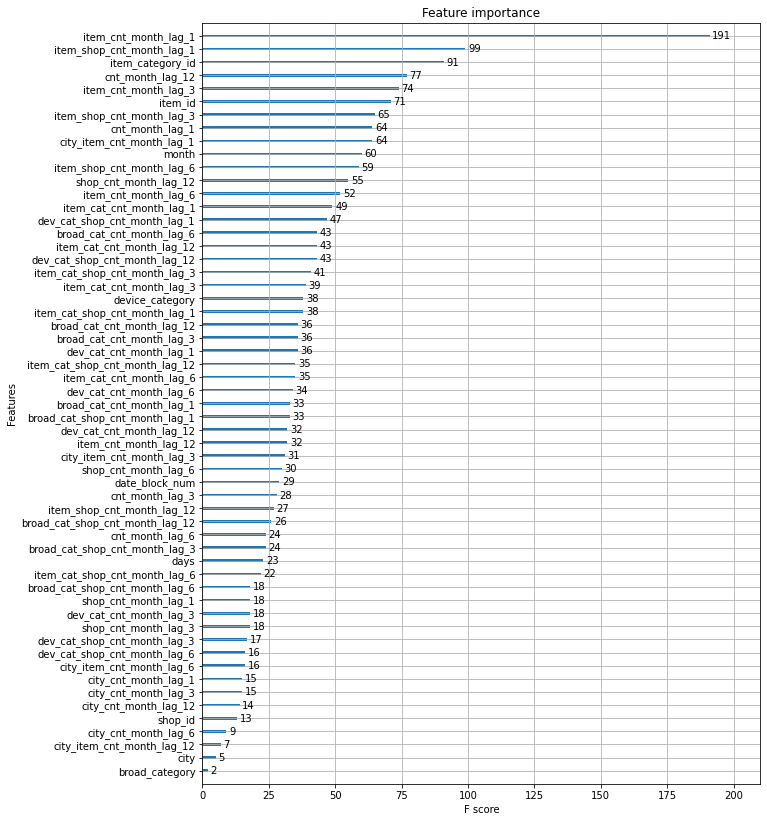

In [93]:
plot_features(model, (10,14))

### With pricing columns, label encoded categorical features

### ** DECIDE ON PRICING , target mean encoded features